In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skt
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re
import collections
from nltk.tokenize import RegexpTokenizer

# Loading the dataset

In [2]:
from google.colab import drive

# Monter Google Drive
drive.mount('/content/drive')

# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/FakeNewsNet Dataset/gossipcop_real.csv'

# Charger le fichier CSV
true_df = pd.read_csv(file_path)

# Vérification des premières lignes du dataframe
true_df.head()

Mounted at /content/drive


,id,news_url,title,tweet_ids
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...


In [3]:
# Chemin vers le fichier dans Google Drive
file_path = '/content/drive/My Drive/FakeNewsNet Dataset/gossipcop_fake.csv'

# Charger le fichier CSV
fake_df = pd.read_csv(file_path)
fake_df.head()

,id,news_url,title,tweet_ids
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...


# Data Preprocessing

Preprocessing of true and fake datasets for data optimisation and removal of blank and duplicate entries.

## Verified News Dataset

In [4]:
# TRUE DATASET
# Checking for NaN values
true_df.isna().sum()

,0
id,0
news_url,13
title,0
tweet_ids,1058


In [5]:
true_df['title']

,title
0,Teen Mom Star Jenelle Evans' Wedding Dress Is ...
1,Kylie Jenner refusing to discuss Tyga on Life ...
2,Quinn Perkins
3,I Tried Kim Kardashian's Butt Workout & Am For...
4,Celine Dion donates concert proceeds to Vegas ...
...,...
16812,2017 Hollywood Film Awards: The Complete List ...
16813,Jada Pinkett Smith explains why son Jaden move...
16814,Tinsley Mortimer Reacts to Luann de Lesseps' R...
16815,Prince Harry Carries on Princess Diana’s Legac...


In [6]:
# Define function for most common words
# https://github.com/remydeshayes/NLP_Pytorch/blob/main/Notebook%20-%20Fake_News%20Detection%20Pytorch%20-%20Billiot_Deshayes.ipynb
from collections import Counter


def most_common(corpus, nb_words):
    articles = corpus.str.split()
    # Explanation of nested list comprehension:
    # Iterate through every article in articles
    # Iterate through every word in article (second for in loop)
    # Add word to the np.array if it is not a stopword (nltk)
    words = np.array([word for article in articles for word in article if word.lower() not in stopwords])
    counter = Counter(words)
    d = pd.DataFrame(counter, index=['occurences']).transpose().reset_index()
    d.columns = ['word', 'occurences']
    d = d.sort_values('occurences', ascending=False)
    return d[:nb_words]

In [7]:
# Download stopwords from nltk library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# This is VERY HIGH cpu compute (but it only takes a few seconds)
most_common(true_df['title'], 10)

,word,occurences
22,&,752
335,New,620
192,Kardashian,561
339,2018,524
66,Awards,489
52,Season,477
18,Kim,410
252,Prince,381
73,First,351
688,Meghan,348


In [9]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output text clutter
duplicate = true_df['title'].value_counts()[true_df['title'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,- USweekly,12
1,This Is Us: Sterling K Brown Tells Us Why Rand...,11
2,Wedding of Prince Harry and Meghan Markle,9
3,Celebritymaximum.com,8
4,Why Nikki Bella Hid Her First Marriage from Jo...,8
...,...,...
556,14 Signs Bella Hadid and The Weeknd Are Gettin...,2
557,This Is Us (season 2),2
558,‘Dancing With the Stars’ finale: Why no one ha...,2
559,Zac Efron Confirms That He Can Sing in The Gre...,2


In [10]:
# Number of duplicate entries
true_df['title'].value_counts()[true_df['title'].value_counts()>1].sum() - 212

1199

In [11]:
# Deletion of duplicates
true_df = true_df.drop_duplicates(subset=['title'], ignore_index=True)

In [12]:
true_df.shape

(15967, 4)

In [13]:
true_df

,id,news_url,title,tweet_ids
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...
...,...,...,...,...
15962,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...
15963,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...
15964,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...
15965,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...


In [14]:
true_df['real'] = 1
true_df['fake'] = 0

In [15]:
true_df

,id,news_url,title,tweet_ids,real,fake
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...,1,0
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...,1,0
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...,1,0
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...,1,0
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...,1,0
...,...,...,...,...,...,...
15962,gossipcop-891749,https://omgcheckitout.com/2017-hollywood-film-...,2017 Hollywood Film Awards: The Complete List ...,927385466357260288\t927386601034010625\t927387...,1,0
15963,gossipcop-941486,https://pagesix.com/2018/06/04/jada-pinkett-sm...,Jada Pinkett Smith explains why son Jaden move...,1004044947006386178\t1004045964401889285\t1004...,1,0
15964,gossipcop-953143,https://www.etonline.com/tinsley-mortimer-reac...,Tinsley Mortimer Reacts to Luann de Lesseps' R...,1019924845889572864\t1019925702676709377\t1019...,1,0
15965,gossipcop-954366,https://www.healthbreakingnews.net/2018/07/pri...,Prince Harry Carries on Princess Diana’s Legac...,1021766291139584000\t1021772054599802880\t1021...,1,0


## False News Dataset

We preprocess the articles in a similar manner as the true dataset

In [16]:
# FAKE DATASET
# Checking for NaN values
fake_df.isna().sum()

,0
id,0
news_url,256
title,0
tweet_ids,188


In [17]:
# Check for duplicates or blank articles
# Conversion to dataframe to reduce output textitlet clutter
duplicate = fake_df['title'].value_counts()[fake_df['title'].value_counts()>1]
duplicate = duplicate.rename_axis('unique_values').reset_index(name='counts')
duplicate

,unique_values,counts
0,Connecting People Through News,20
1,Female First Forum,11
2,Brad Pitt and Jennifer Aniston 'busted' over A...,8
3,Jennifer Lopez Is Questioning Her Future With ...,6
4,Gwen Stefani Is Still Smitten With Blake Shelt...,6
...,...,...
290,Liam Hemsworth,2
291,Actor Tom Cruise Proposes to Girlfriend Katie ...,2
292,A Timeline of the Complicated Relationship Bet...,2
293,Brad Pitt fires back at Angelina Jolie's child...,2


In [18]:
fake_df['title'].value_counts()[fake_df['title'].value_counts()>1].sum() - 4927 - 626

-4831

In [19]:
# Values with no text - only title
blank = fake_df.loc[fake_df["title"] == duplicate["unique_values"][0]]
blank

,id,news_url,title,tweet_ids
408,gossipcop-5793704644,www.pressreader.com/india/the-sunday-guardian/...,Connecting People Through News,822376317953843200\t822376774164090880\t822377...
1006,gossipcop-8293006687,www.pressreader.com/new-zealand/womans-day-nz/...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...
1079,gossipcop-9080361625,www.pressreader.com/usa/in-touch-usa/20180323/...,Connecting People Through News,895585055690575872\t895672153496051712\t895784...
1779,gossipcop-8328156845,www.pressreader.com/usa/life-style-weekly/2018...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...
3059,gossipcop-9955703756,www.pressreader.com/australia/womans-day-austr...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...
3069,gossipcop-8049563330,www.pressreader.com/australia/nw/20180430/2835...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...
3358,gossipcop-905546659,www.pressreader.com/australia/nw/20180305/2841...,Connecting People Through News,857607295668289536\t857746231967318018\t858053...
3638,gossipcop-5650911362,www.pressreader.com/usa/life-style-weekly/2018...,Connecting People Through News,903251560905547777\t903275410527420416\t903409...
3671,gossipcop-3264479815,www.pressreader.com/australia/ok-australia/201...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...
3725,gossipcop-5660970075,www.pressreader.com/new-zealand/womans-day-nz/...,Connecting People Through News,900336607680761857\t900407896072216576\t900412...


In [20]:
blank.index

Index([ 408, 1006, 1079, 1779, 3059, 3069, 3358, 3638, 3671, 3725, 3777, 3877,
       4034, 4122, 4166, 4186, 4228, 4485, 5074, 5269],
      dtype='int64')

In [21]:
# Dropping the blank news from the fake dataframe
fake_df = fake_df.drop(blank.index)

In [22]:
# Verification of removal (verified)
fake_df

,id,news_url,title,tweet_ids
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...
...,...,...,...,...
5318,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080
5319,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...
5320,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...
5321,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...


In [23]:
# Deletion of duplicates
fake_df = fake_df.drop_duplicates(subset=['title'], ignore_index=True)

In [24]:
fake_df

,id,news_url,title,tweet_ids
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...
...,...,...,...,...
4890,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080
4891,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...
4892,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...
4893,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...


In [25]:
fake_df['real'] = 0
fake_df['fake'] = 1

<ipython-input-25-67d463e65983>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['real'] = 0
<ipython-input-25-67d463e65983>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['fake'] = 1


Finally we concatenate both the dataframe

In [26]:
data = pd.concat([true_df, fake_df])
data = data.reset_index(drop=True)

In [27]:
data

,id,news_url,title,tweet_ids,real,fake
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,Teen Mom Star Jenelle Evans' Wedding Dress Is ...,912371411146149888\t912371528343408641\t912372...,1,0
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,Kylie Jenner refusing to discuss Tyga on Life ...,901989917546426369\t901989992074969089\t901990...,1,0
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,Quinn Perkins,931263637246881792\t931265332022579201\t931265...,1,0
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,I Tried Kim Kardashian's Butt Workout & Am For...,868114761723936769\t868122567910936576\t868128...,1,0
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,Celine Dion donates concert proceeds to Vegas ...,915528047004209152\t915529285171122176\t915530...,1,0
...,...,...,...,...,...,...
20857,gossipcop-6702260693,www.huffingtonpost.com/2012/09/11/september-11...,September 11: Celebrities Remember 9/11 (TWEETS),245643768638894080,0,1
20858,gossipcop-6051845337,www.dailymail.co.uk/news/article-4915674/NASCA...,NASCAR owners threaten to fire drivers who pro...,912048333413330944\t912048571482087424\t912049...,0,1
20859,gossipcop-2435526162,www.telegraph.co.uk/men/the-filter/7-signs-dav...,The 7 signs that David Beckham is definitely h...,897794716447539200\t897804460830928896\t897842...,0,1
20860,gossipcop-4576152851,www.vanityfair.com/style/2016/09/ryan-gosling-...,Ryan Gosling and Eva Mendes Did Not Get Marrie...,778678901572710400\t778681718714740736\t778683...,0,1


In [28]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

print("Number of words in dataset:", data['title'].apply(lambda x: len(x.split(' '))).sum())

Number of words in dataset: 236717


In [29]:
data.iloc[0,0:]

,0
id,gossipcop-882573
news_url,https://www.brides.com/story/teen-mom-jenelle-...
title,Teen Mom Star Jenelle Evans' Wedding Dress Is ...
tweet_ids,912371411146149888\t912371528343408641\t912372...
real,1
fake,0


In [30]:
number_of_samples=data.iloc[:,0].count()

In [31]:
y=data.iloc[:,8:].sum(axis=1).value_counts()/data.iloc[:,0].count()*100

# Exploratory Data Analysis

In [32]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-33-5b14143a0517>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(y='Average character length', x='Label', data=av, palette=colors)


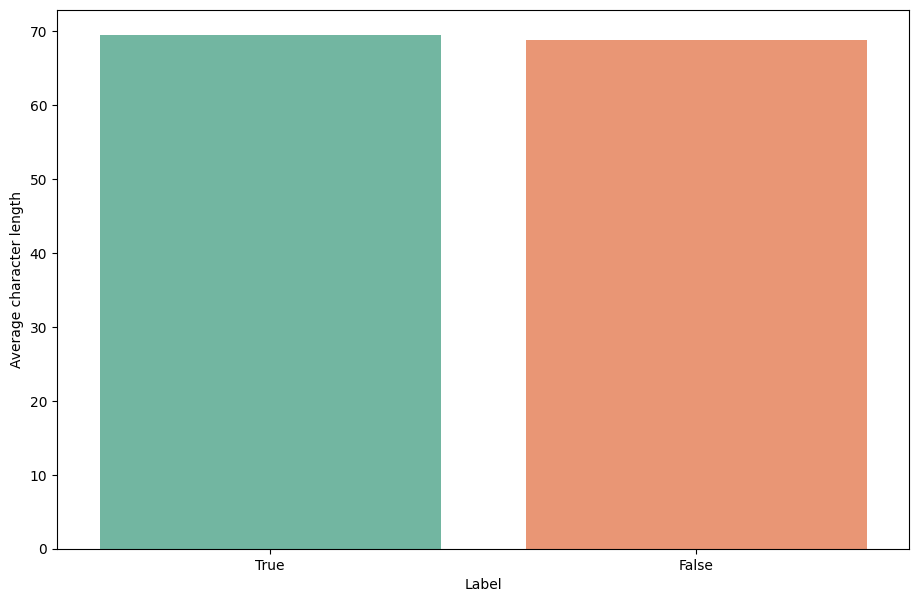

In [33]:
# Text analysis
av_t = data[data['real'] == 1]['title'].apply(lambda x: len(x)).mean()
av_f = data[data['fake'] == 1]['title'].apply(lambda x: len(x)).mean()
av = pd.DataFrame(data = {'Average character length': [av_t, av_f], 'Label':['True', 'False']})
fig, bar = plt.subplots(figsize = (11,7))

colors = sns.color_palette("Set2", 2)

bar = sns.barplot(y='Average character length', x='Label', data=av, palette=colors)

### Most common words

<ipython-input-34-413c5872692d>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
<ipython-input-34-413c5872692d>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);


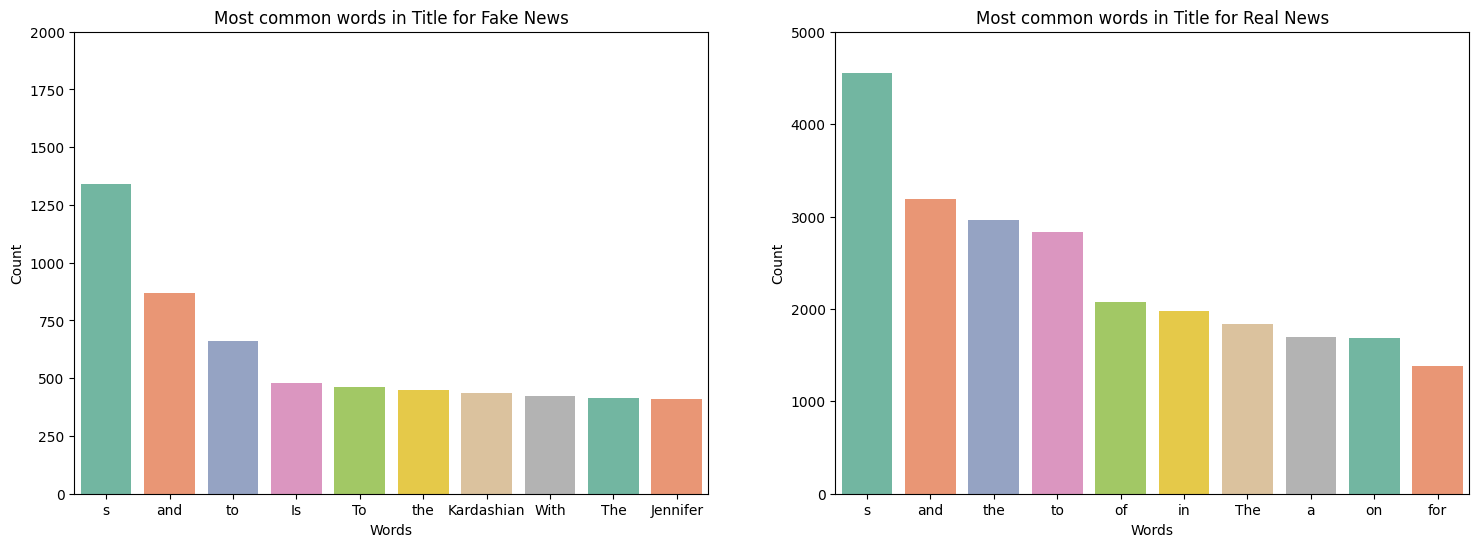

In [34]:

def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

fake_titles = data[data['fake']== 1]['title'].tolist()
real_titles = data[data['real']==1]['title'].tolist()

# word count

fake0_wrd = get_wrd_count(fake_titles)
real1_wrd = get_wrd_count(real_titles)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]
#print(l1, h1)

colors = sns.color_palette("Set2", 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
ax[0].set_ylim(top=2000);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Most common words in Title for Fake News");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);
ax[1].set_ylim(top=5000);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Most common words in Title for Real News");

# Text Pre-processing

In [35]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 11.1 MB/s eta 0:00:00


In [36]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=ed5fedf2ffce7e64f44f4eeafd4616ef6190ff9738827cccf3a52012a853d75b
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [37]:
# Importing Libraries
import unidecode
import pandas as pd
import re
import time
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import word_tokenize
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
def remove_hash(text1):
      return text1.replace("''", "")

In [39]:
def remove_tag(text2):
      return text2.replace("'", "")

In [40]:
def remove_tag(text3):
      return text3.replace("'", "")

In [41]:
def remove_underscore(text):
      return text.replace("_", " ")

In [42]:
data['title']=data['title'].apply(lambda text1: remove_hash(text1))

In [43]:
data['title']=data['title'].apply(lambda text2: remove_tag(text2))

In [44]:
data['title']=data['title'].apply(lambda text3: remove_tag(text3))

In [45]:
data['title']=data['title'].apply(lambda text: remove_underscore(text))

# Remove newlines & Tabs

In [46]:
def remove_newlines_tabs(text):
    """
    This function will remove all the occurrences of newlines, tabs, and combinations like: \\n, \\.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of newlines, tabs, \\n, \\ characters.

    Example:
    Input : This is her \\ first day at this place.\n Please,\t Be nice to her.\\n
    Output : This is her first day at this place. Please, Be nice to her.
    """

    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    return Formatted_text

In [47]:
data['title']=data['title'].apply(remove_newlines_tabs)

# Strip HTML Tags

In [48]:
def strip_html_tags(text):
    """
    This function will remove all the occurrences of html tags from the text.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of html tags.

    Example:
    Input : This is a nice place to live. <IMG>
    Output : This is a nice place to live.
    """
    # Initiating BeautifulSoup object soup.
    soup = BeautifulSoup(text, "html.parser")
    # Get all the text other than html tags.
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

In [49]:
data['title']=data['title'].apply(strip_html_tags)

<ipython-input-48-e98537e2dbe3>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


# Remove Links

In [50]:
def remove_links(text):
    """
    This function will remove all the occurrences of links.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" after removal of all types of links.

    Example:
    Input : To know more about this website: kajalyadav.com  visit: https://kajalyadav.com//Blogs
    Output : To know more about this website: visit:

    """

    # Removing all the occurrences of links that starts with https
    remove_https = re.sub(r'http\S+', '', text)
    # Remove all the occurrences of text that ends with .com
    remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
    return remove_com

In [51]:
data['title']=data['title'].apply(remove_links)

# Remove Accented Characters

In [52]:
# Code for accented characters removal
def accented_characters_removal(text):
    # this is a docstring
    """
    The function will remove accented characters from the
    text contained within the Dataset.

    arguments:
        input_text: "text" of type "String".

    return:
        value: "text" with removed accented characters.

    Example:
    Input : Málaga, àéêöhello
    Output : Malaga, aeeohello

    """
    # Remove accented characters from text using unidecode.
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters.
    text = unidecode.unidecode(text)
    return text

In [53]:
data['title']=data['title'].apply(accented_characters_removal)

# Expand Contractions

In [54]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}
# The code for expanding contraction words
def expand_contractions(text, contraction_mapping =  CONTRACTION_MAP):
    """expand shortened words to the actual form.
       e.g. don't to do not

       arguments:
            input_text: "text" of type "String".

       return:
            value: Text with expanded form of shorthened words.

       Example:
       Input : ain't, aren't, can't, cause, can't've
       Output :  is not, are not, cannot, because, cannot have

     """
    # Tokenizing text into tokens.
    list_Of_tokens = text.split(' ')

    # Checking for whether the given token matches with the Key & replacing word with key's value.

    # Check whether Word is in lidt_Of_tokens or not.
    for Word in list_Of_tokens:
        # Check whether found word is in dictionary "Contraction Map" or not as a key.
         if Word in CONTRACTION_MAP:
                # If Word is present in both dictionary & list_Of_tokens, replace that word with the key value.
                list_Of_tokens = [item.replace(Word, CONTRACTION_MAP[Word]) for item in list_Of_tokens]

    # Converting list of tokens to String.
    String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens)
    return String_Of_tokens

In [55]:
data['title']=data['title'].apply(expand_contractions)

## Removing special characters except (!,?)

In [56]:
# The code for removing special characters except (!,?)
def removing_special_characters(text):
    """Removing all the special characters except the one that is passed within
       the regex to match, as they have imp meaning in the text provided.


    arguments:
         input_text: "text" of type "String".

    return:
        value: Text with removed special characters that don't require.

    Example:
    Input : Hello, K-a-j-a-l. Thi*s is $100.05 : the payment that you will recieve! (Is this okay?)
    Output :  Hello, Kajal. This is $100.05 : the payment that you will recieve! Is this okay?

   """
    # The formatted text after removing not necessary punctuations.
    Formatted_Text = re.sub(r"[^a-zA-Z0-9:$-,%.@_#""'']+", ' ', text)
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return Formatted_Text

In [57]:
data['title']=data['title'].apply(removing_special_characters)

In [58]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [59]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Removing stopwords

In [60]:
# The code for removing stopwords
stoplist = stopwords.words('english')
stoplist = set(stoplist)
def removing_stopwords(text):
    """This function will remove stopwords which doesn't add much meaning to a sentence
       & they can be remove safely without comprimising meaning of the sentence.

    arguments:
         input_text: "text" of type "String".

    return:
        value: Text after omitted all stopwords.

    Example:
    Input : This is Kajal from delhi who came here to study.
    Output : ["'This", 'Kajal', 'delhi', 'came', 'study', '.', "'"]

   """
    # repr() function actually gives the precise information about the string
    text = repr(text)
    # Text without stopwords
    No_StopWords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convert list of tokens_without_stopwords to String type.
    words_string = ' '.join(No_StopWords)
    return words_string

In [61]:
data['title']=data['title'].apply(removing_stopwords)

data.to_csv('data1.csv', index=False)

# Most frequent words

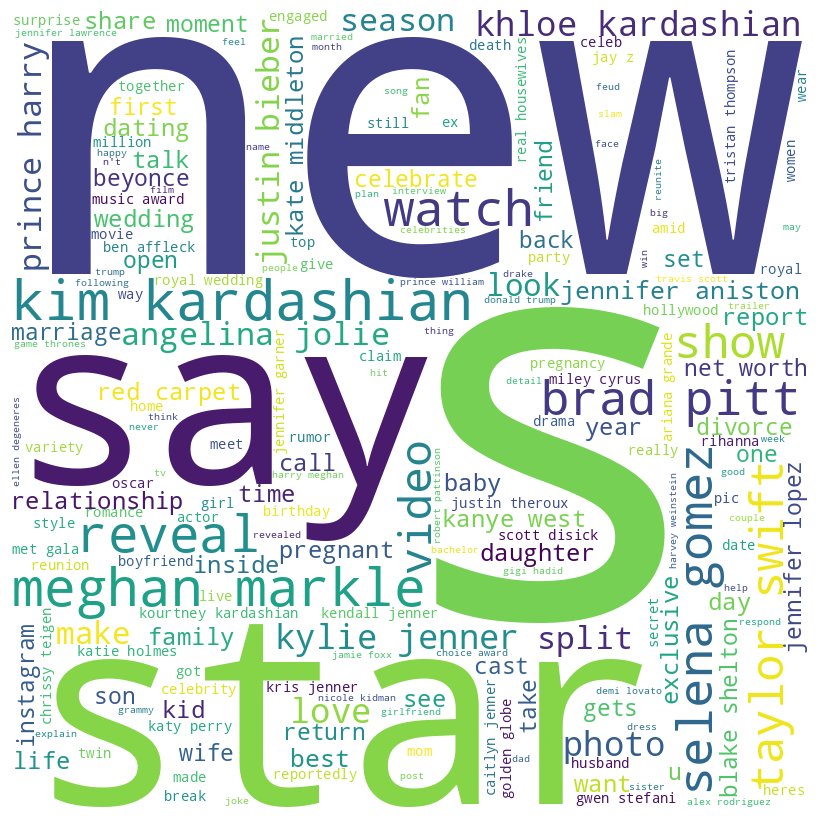

In [62]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Reads
df = data

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.title:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10,
                      font_path=None).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [63]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from sklearn.feature_extraction.text import CountVectorizer

# Fonction pour obtenir les bigrammes les plus fréquents
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Obtenir les 20 bigrammes les plus fréquents
common_words = get_top_n_bigram(data['title'], 20)
for word, freq in common_words:
    print(word, freq)

kim kardashian 476
meghan markle 389
selena gomez 368
brad pitt 359
taylor swift 289
kylie jenner 288
khloe kardashian 283
angelina jolie 283
justin bieber 271
prince harry 267
jennifer aniston 255
red carpet 209
kanye west 206
kate middleton 173
net worth 167
blake shelton 162
jennifer lopez 161
katy perry 147
scott disick 143
gwen stefani 141


<ipython-input-64-dd24e981a132>:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-64-dd24e981a132>:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




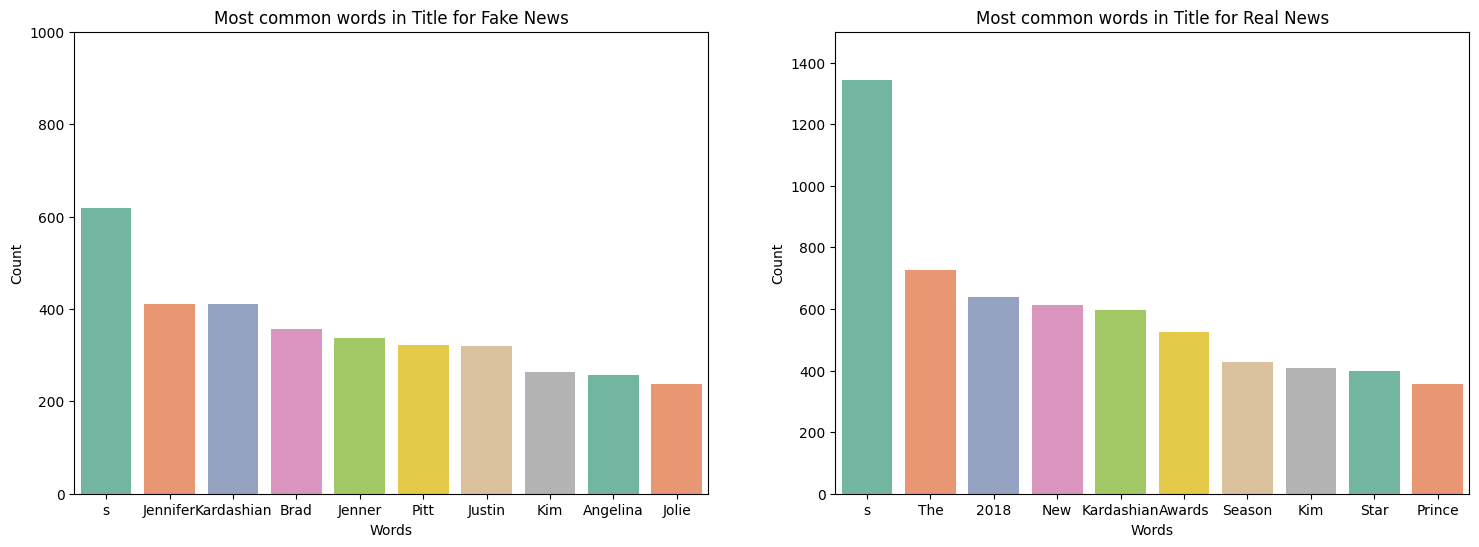

In [64]:
def get_wrd_count(text_lst):
    all_wrds = []
    tokenizer = RegexpTokenizer(r'\w+')
    for txt in text_lst:
        wrds = tokenizer.tokenize(txt)
        all_wrds.extend(wrds)
    wrd_counter = collections.Counter(all_wrds)
    return wrd_counter

fake_titles = data[data['fake']== 1]['title'].tolist()
real_titles = data[data['real']==1]['title'].tolist()

# word count

fake0_wrd = get_wrd_count(fake_titles)
real1_wrd = get_wrd_count(real_titles)

fake0_wrd_cnt_sorted = fake0_wrd.most_common(n=10)
real1_wrd_cnt_sorted = real1_wrd.most_common(n=10)
l0, h0, l1, h1 = [],[],[],[]
_ = [(l0.append(i[0]), h0.append(i[1])) for i in fake0_wrd_cnt_sorted]
_ = [(l1.append(i[0]), h1.append(i[1])) for i in real1_wrd_cnt_sorted]
#print(l1, h1)

colors = sns.color_palette("Set2", 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6));
sns.barplot(x=list(range(len(l0))), y=h0, ax=ax[0], palette=colors);
ax[0].set_ylim(top=1000);
ax[0].set_xticks(ticks = list(range(len(l0))));
ax[0].set_xticklabels(l0);
ax[0].set_xlabel('Words');
ax[0].set_ylabel('Count');
ax[0].set_title("Most common words in Title for Fake News");

sns.barplot(x=list(range(len(l1))), y=h1, ax=ax[1], palette=colors);
ax[1].set_ylim(top=1500);
ax[1].set_xticks(ticks = list(range(len(l1))));
ax[1].set_xticklabels(l1);
ax[1].set_xlabel('Words');
ax[1].set_ylabel('Count');
ax[1].set_title("Most common words in Title for Real News");

In [65]:
import pandas as pd
import numpy as np
from textblob import TextBlob, Word, Blobber

In [66]:
data['polarity'] = data['title'].map(lambda text: TextBlob(text).sentiment.polarity)

In [67]:
print(data.shape)

(20862, 7)


In [68]:
data.head(4)

,id,news_url,title,tweet_ids,real,fake,polarity
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,'Teen Mom Star Jenelle Evans Wedding Dress Ava...,912371411146149888\t912371528343408641\t912372...,1,0,0.2
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,'Kylie Jenner refusing discuss Tyga Life Kylie ',901989917546426369\t901989992074969089\t901990...,1,0,0.0
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,'Quinn Perkins ',931263637246881792\t931265332022579201\t931265...,1,0,0.0
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,' Tried Kim Kardashians Butt Workout & Forever...,868114761723936769\t868122567910936576\t868128...,1,0,0.0


In [69]:
data = data[['id', 'news_url', 'title','polarity', 'real','fake']]

In [70]:
data.head()

,id,news_url,title,polarity,real,fake
0,gossipcop-882573,https://www.brides.com/story/teen-mom-jenelle-...,'Teen Mom Star Jenelle Evans Wedding Dress Ava...,0.2,1,0
1,gossipcop-875924,https://www.dailymail.co.uk/tvshowbiz/article-...,'Kylie Jenner refusing discuss Tyga Life Kylie ',0.0,1,0
2,gossipcop-894416,https://en.wikipedia.org/wiki/Quinn_Perkins,'Quinn Perkins ',0.0,1,0
3,gossipcop-857248,https://www.refinery29.com/en-us/2018/03/19192...,' Tried Kim Kardashians Butt Workout & Forever...,0.0,1,0
4,gossipcop-884684,https://www.cnn.com/2017/10/04/entertainment/c...,'Celine Dion donates concert proceeds Vegas sh...,0.0,1,0


In [71]:
data.fillna(value='', inplace=True)

In [72]:
import csv
data.to_csv("polarity_results.csv", index=False)

In [73]:
import numpy as np

data['polarity'] = np.asarray(data.polarity).astype(np.float32)

In [74]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, GRU, Dropout
from sklearn.model_selection import train_test_split

### Performing train test split

In [75]:
# text + metadata
train_split_fraction=0.8
split_index=int(number_of_samples*train_split_fraction)
data=data.sample(frac=1)
X_train,ytrain=data.iloc[:split_index,2], data.iloc[:split_index,4:]
X_test,ytest=data.iloc[split_index:,2], data.iloc[split_index:,4:]
X_Num_train,y_Numtrain=data.iloc[:split_index,[3]], data.iloc[:split_index,4:]
X_Num_test,y_Numtest=data.iloc[split_index:,[3]], data.iloc[split_index:,4:]

In [76]:
split_index

16689

In [77]:
data.head(5)

,id,news_url,title,polarity,real,fake
11322,gossipcop-927936,https://www.usmagazine.com/celebrity-news/news...,'Brooke Burke Opens David Charvet Divorce ',0.000000,1,0
11423,gossipcop-915663,https://ew.com/tv/2018/02/22/flash-iris-speeds...,'The Flash first look : Find Iris gets powers ',0.250000,1,0
10425,gossipcop-854540,http://toofab.com/photos/pirates-of-the-caribb...,'Pirates Caribbean : Dead Men Tell Tales Premi...,-0.200000,1,0
884,gossipcop-875977,http://www.bravotv.com/the-daily-dish/mtv-vmas...,'Taylor Swifts New Video Proves Officially Giv...,0.218182,1,0
5064,gossipcop-954484,https://www.etonline.com/ariana-grande-is-taki...,'Ariana Grande Taking Breather Social Media Fi...,0.033333,1,0


In [78]:
print(data.shape)

(20862, 6)


In [79]:
# find the length of the largest sentence in training data
max_len = X_train.apply(lambda x: len(x)).max()
print(f'Max number of words in a text in training data: {max_len}')

Max number of words in a text in training data: 209


In [80]:
X_train.head(3)

,title
11322,'Brooke Burke Opens David Charvet Divorce '
11423,'The Flash first look : Find Iris gets powers '
10425,'Pirates Caribbean : Dead Men Tell Tales Premi...


In [81]:
ytrain.head(3)

,real,fake
11322,1,0
11423,1,0
10425,1,0


In [82]:
X_test.head(3)

,title
8856,'Solange Knowles Reveals Autonomic Disorder Di...
7766,'Get Kerry Washingtons Entire Look $ 150 ( Boo...
6820,'The Beauty Secret Celebs Make Bodies Shine '


In [83]:
ytest.head (3)

,real,fake
8856,1,0
7766,1,0
6820,1,0


In [84]:
X_Num_train.head(3)

,polarity
11322,0.00
11423,0.25
10425,-0.20


In [85]:
y_Numtrain.head(3)

,real,fake
11322,1,0
11423,1,0
10425,1,0


In [86]:
X_Num_test.head(3)

,polarity
8856,0.136364
7766,0.000000
6820,-0.400000


In [87]:
y_Numtest.head(3)

,real,fake
8856,1,0
7766,1,0
6820,1,0


In [88]:
X_Num_train

,polarity
11322,0.000000
11423,0.250000
10425,-0.200000
884,0.218182
5064,0.033333
...,...
15548,-0.025000
20313,0.000000
1333,0.800000
6132,0.100000


In [89]:
X_Num_test

,polarity
8856,0.136364
7766,0.000000
6820,-0.400000
1299,0.000000
12937,0.000000
...,...
7621,0.500000
17936,0.300000
4430,1.000000
883,0.000000


#### Defining constants for padding, size of vocabulary

In [90]:
vocab_size = 10000
oov_token = "<OOV>"
max_length = 300
padding_type = "post"
trunction_type="post"

In [91]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [92]:
print(tokenizer.num_words)

10000


# Word Indexing:The most frequent word would have index=1 and so on...

In [93]:
word_index = tokenizer.word_index
print(word_index)

{'<OOV>': 1, "'": 2, "''": 3, "'s": 4, 'kardashian': 5, 'new': 6, "'the": 7, 'jenner': 8, '2018': 9, 'baby': 10, 'wedding': 11, 'star': 12, 'awards': 13, 'says': 14, 'season': 15, 'first': 16, 'reveals': 17, 'jennifer': 18, 'markle': 19, 'best': 20, 'gomez': 21, 'stars': 22, 'meghan': 23, 'pitt': 24, 'show': 25, 'prince': 26, 'justin': 27, '2017': 28, 'love': 29, 'see': 30, 'harry': 31, 'video': 32, 'kim': 33, 'back': 34, 'split': 35, 'family': 36, "'kim": 37, 'get': 38, '2': 39, 'birthday': 40, 'west': 41, 'life': 42, 'day': 43, 'swift': 44, 'daughter': 45, 'jolie': 46, "'jennifer": 47, 'brad': 48, "'how": 49, 'divorce': 50, 'dating': 51, 'time': 52, 'year': 53, 'tv': 54, 'relationship': 55, 'bieber': 56, 'report': 57, 'ex': 58, 'watch': 59, 'years': 60, 'aniston': 61, 'rumors': 62, 'taylor': 63, 'selena': 64, 'look': 65, 'trump': 66, 'shares': 67, 'scott': 68, 'mom': 69, 'like': 70, 'royal': 71, 'music': 72, 'kate': 73, '3': 74, 'news': 75, '5': 76, 'kylie': 77, 'red': 78, 'photos': 

In [94]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
print(X_train_sequences)

[[3360, 2384, 180, 243, 4966, 50, 2], [7, 1944, 16, 65, 702, 5897, 93, 4967, 2], [4968, 1945, 290, 837, 838, 4255, 184, 2], [158, 587, 6, 32, 1265, 812, 199, 3760, 1, 1021, 1266, 137, 7340, 2], [503, 269, 866, 1, 475, 367, 703, 1161, 867, 5898, 114, 2], [1022, 189, 2070, 138, 3361, 2214, 246, 4969, 9, 2], [5899, 1, 1, 813, 11, 1, 432, 1, 2], [556, 1023, 752, 4970, 345, 676, 2215, 345, 1, 981, 2], [217, 1162, 1, 660, 23, 19, 795, 1, 182, 71, 11, 1, 2], [1067, 1378, 177, 12, 518, 2071, 3761, 7341, 528, 43, 119, 218, 2], [588, 982, 2216, 2], [1558, 677, 5900, 2217, 1111, 4971, 9, 1024, 205, 13, 2], [368, 421, 953, 2, 704, 1379, 4256, 184, 3], [1, 3762, 3026, 422, 660, 1831, 3762, 1, 29, 2], [5901, 5902, 2767, 200, 7342, 273, 1, 2], [141, 638, 570, 868, 1, 208, 571, 9, 1025, 13, 2], [3027, 3028, 7343, 444, 894, 839, 1, 2768, 771, 2], [4972, 45, 3029, 1068, 3362, 1267, 1714, 5903, 2218, 840, 1380, 2], [4257, 250, 3363, 2769, 1, 125, 589, 2], [1470, 231, 132, 102, 2], [7344, 590, 2], [2385, 

In [95]:
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type,
                       truncating=trunction_type)

In [96]:
print(X_train_padded.shape)

(16689, 300)


In [97]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_Num_train)

# transform training data
X_Num_train_norm = norm.transform(X_Num_train)

# transform testing dataabs
X_Num_test_norm = norm.transform(X_Num_test)

In [98]:
print(X_Num_train_norm.shape)


(16689, 1)


In [99]:
print('text example:', X_train[200])
print('sequence of indices(before padding):', X_train_sequences[220])
print('sequence of indices(after padding):', X_train_padded[220])


text example: 'Prince Harry Meghan Markle Channel Princess Diana Nelson Mandela Exhibit '
sequence of indices(before padding): [1, 2086, 875, 7413, 3801, 780, 4303, 3052, 2]
sequence of indices(after padding): [   1 2086  875 7413 3801  780 4303 3052    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    

In [100]:
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length,
                               padding=padding_type, truncating=trunction_type)
X_test_padded

array([[9392, 2180,   17, ...,    0,    0,    0],
       [2221, 3016, 8695, ...,    0,    0,    0],
       [   7,  191,   81, ...,    0,    0,    0],
       ...,
       [ 236,  321, 1116, ...,    0,    0,    0],
       [1560, 1117, 8993, ...,    0,    0,    0],
       [ 277,   46,  180, ...,    0,    0,    0]], dtype=int32)

In [101]:
X_Num_train_norm= X_Num_train_norm.astype(np.float32)
X_Num_train_norm


array([[0.5      ],
       [0.625    ],
       [0.4      ],
       ...,
       [0.9      ],
       [0.55     ],
       [0.5590909]], dtype=float32)

In [102]:
X_Num_test_norm= X_Num_test_norm.astype(np.float32)
X_Num_test_norm

array([[0.5681818],
       [0.5      ],
       [0.3      ],
       ...,
       [1.       ],
       [0.5      ],
       [0.328125 ]], dtype=float32)

### Using Glove  Embedding

In [103]:
import numpy as np

from google.colab import drive
import zipfile

# Monter Google Drive
drive.mount('/content/drive')

# Définir le chemin vers le fichier ZIP
zip_file_path = "/content/drive/MyDrive/glove.840B.300d.zip"

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/glove")

# Définir le chemin vers le fichier GloVe extrait
local_path = "/content/glove/glove.840B.300d.txt"

embeddings_index = {}

# Open the local file for reading
with open(local_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 2195893 word vectors.


In [104]:
#see the vectors of Islamophobia
embeddings_index.get("Islamophobia")[:5]

array([-1.0639  ,  0.17925 ,  0.052323,  0.40803 ,  1.0349  ],
      dtype=float32)

In [105]:
embeddings_index.get("islamophobia")[:5]

array([-0.66834 , -0.020248, -0.35246 ,  0.11967 ,  0.62049 ],
      dtype=float32)

In [106]:
from scipy import spatial
spatial.distance.cosine(embeddings_index["hate"],embeddings_index["love"])

0.3606901109585894

In [107]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [108]:
#initialize the embedding_matrix with zeros
if vocab_size is not None:
    vocab_len = vocab_size
else:
    vocab_len = len(word_index)+1
embedding_matrix = np.zeros((vocab_len, max_length))
oov_count = 0
oov_words = []
for word, idx in word_index.items():
    if idx < vocab_len:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
        else:
            oov_count += 1
            oov_words.append(word)

In [109]:
#print some of the out of vocabulary words
print(f'Some out of valubulary words: {oov_words[0:50]}')

Some out of valubulary words: ['<OOV>', "'the", "'kim", "'jennifer", "'how", "'selena", "'watch", "'prince", "'justin", "'kylie", "'meghan", "'taylor", "'khloe", "'kate", "'why", "'brad", "'this", "'chris", "'is", 'teigen', "'angelina", "'what", "'inside", "'chrissy", "'bachelor", "'beyonce", "'kendall", "'miley", "'all", "'kourtney", 'markles', "'heres", "'tom", "'ben", "'will", "'did", "'jessica", "'nicole", "'john", "'katie", "'ariana", "'blake", "'celebrities", "'are", "'ryan", "'new", "'see", "'teen", "'paris", "'kanye"]


In [110]:
print(f'{oov_count} out of {vocab_len} words were OOV.')

1664 out of 10000 words were OOV.


In [111]:
print(embedding_matrix)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.62620002e-01  5.42450011e-01  7.14249983e-02 ...  1.39909998e-01
   1.85959991e-02 -1.80079998e-03]
 ...
 [ 5.78670025e-01  5.21560013e-02 -2.63590008e-01 ...  7.35650003e-01
  -2.53160000e-01  5.84829986e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.08180004e-01  8.46719965e-02  7.69559965e-02 ...  1.05180005e-02
  -4.40970004e-01  4.40080010e-04]]


In [112]:
print("embedding_matrix.shape:", embedding_matrix.shape)

embedding_matrix.shape: (10000, 300)


### Defining Embedding layer

In [113]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))  # Adapter cette ligne
embedding_layer = Embedding(len(word_index) + 1,
                            max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



# Bi-LSTM Model

In [114]:
import tensorflow as tf
import keras

In [129]:
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Input
from keras.models import Model
from keras.layers import concatenate
from keras.layers import BatchNormalization


In [130]:
from tensorflow.python.keras import regularizers

In [131]:
embedding_dim = 300

nlp_input = Input(shape=(max_length,), name='nlp_input')
meta_input = Input(shape=(1,), name='meta_input')

# Embedding layer
emb = Embedding(output_dim=embedding_dim, input_dim=len(word_index) + 1, input_length=max_length, trainable=True)(nlp_input)

# LSTM layers
nlp_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.01)))(emb)
nlp_out = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.01)))(nlp_out)

# Concatenate metadata input
x = concatenate([nlp_out, meta_input])

# Dense layers with Dropout
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
x = Dense(2, activation='sigmoid')(x)

# Compile model
model = Model(inputs=[nlp_input, meta_input], outputs=[x])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [132]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)    │ (None, 300)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 300, 300)       │      5,434,200 │ nlp_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 300, 256)       │        439,296 │ embedding_3[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 256)            │        394,240 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ meta_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 257)            │              0 │ bidirectional_5[0][0], │
│ (Concatenate)             │                        │                │ meta_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │         66,048 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │            514 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,334,298 (24.16 MB)

 Trainable params: 6,334,298 (24.16 MB)

 Non-trainable params: 0 (0.00 B)

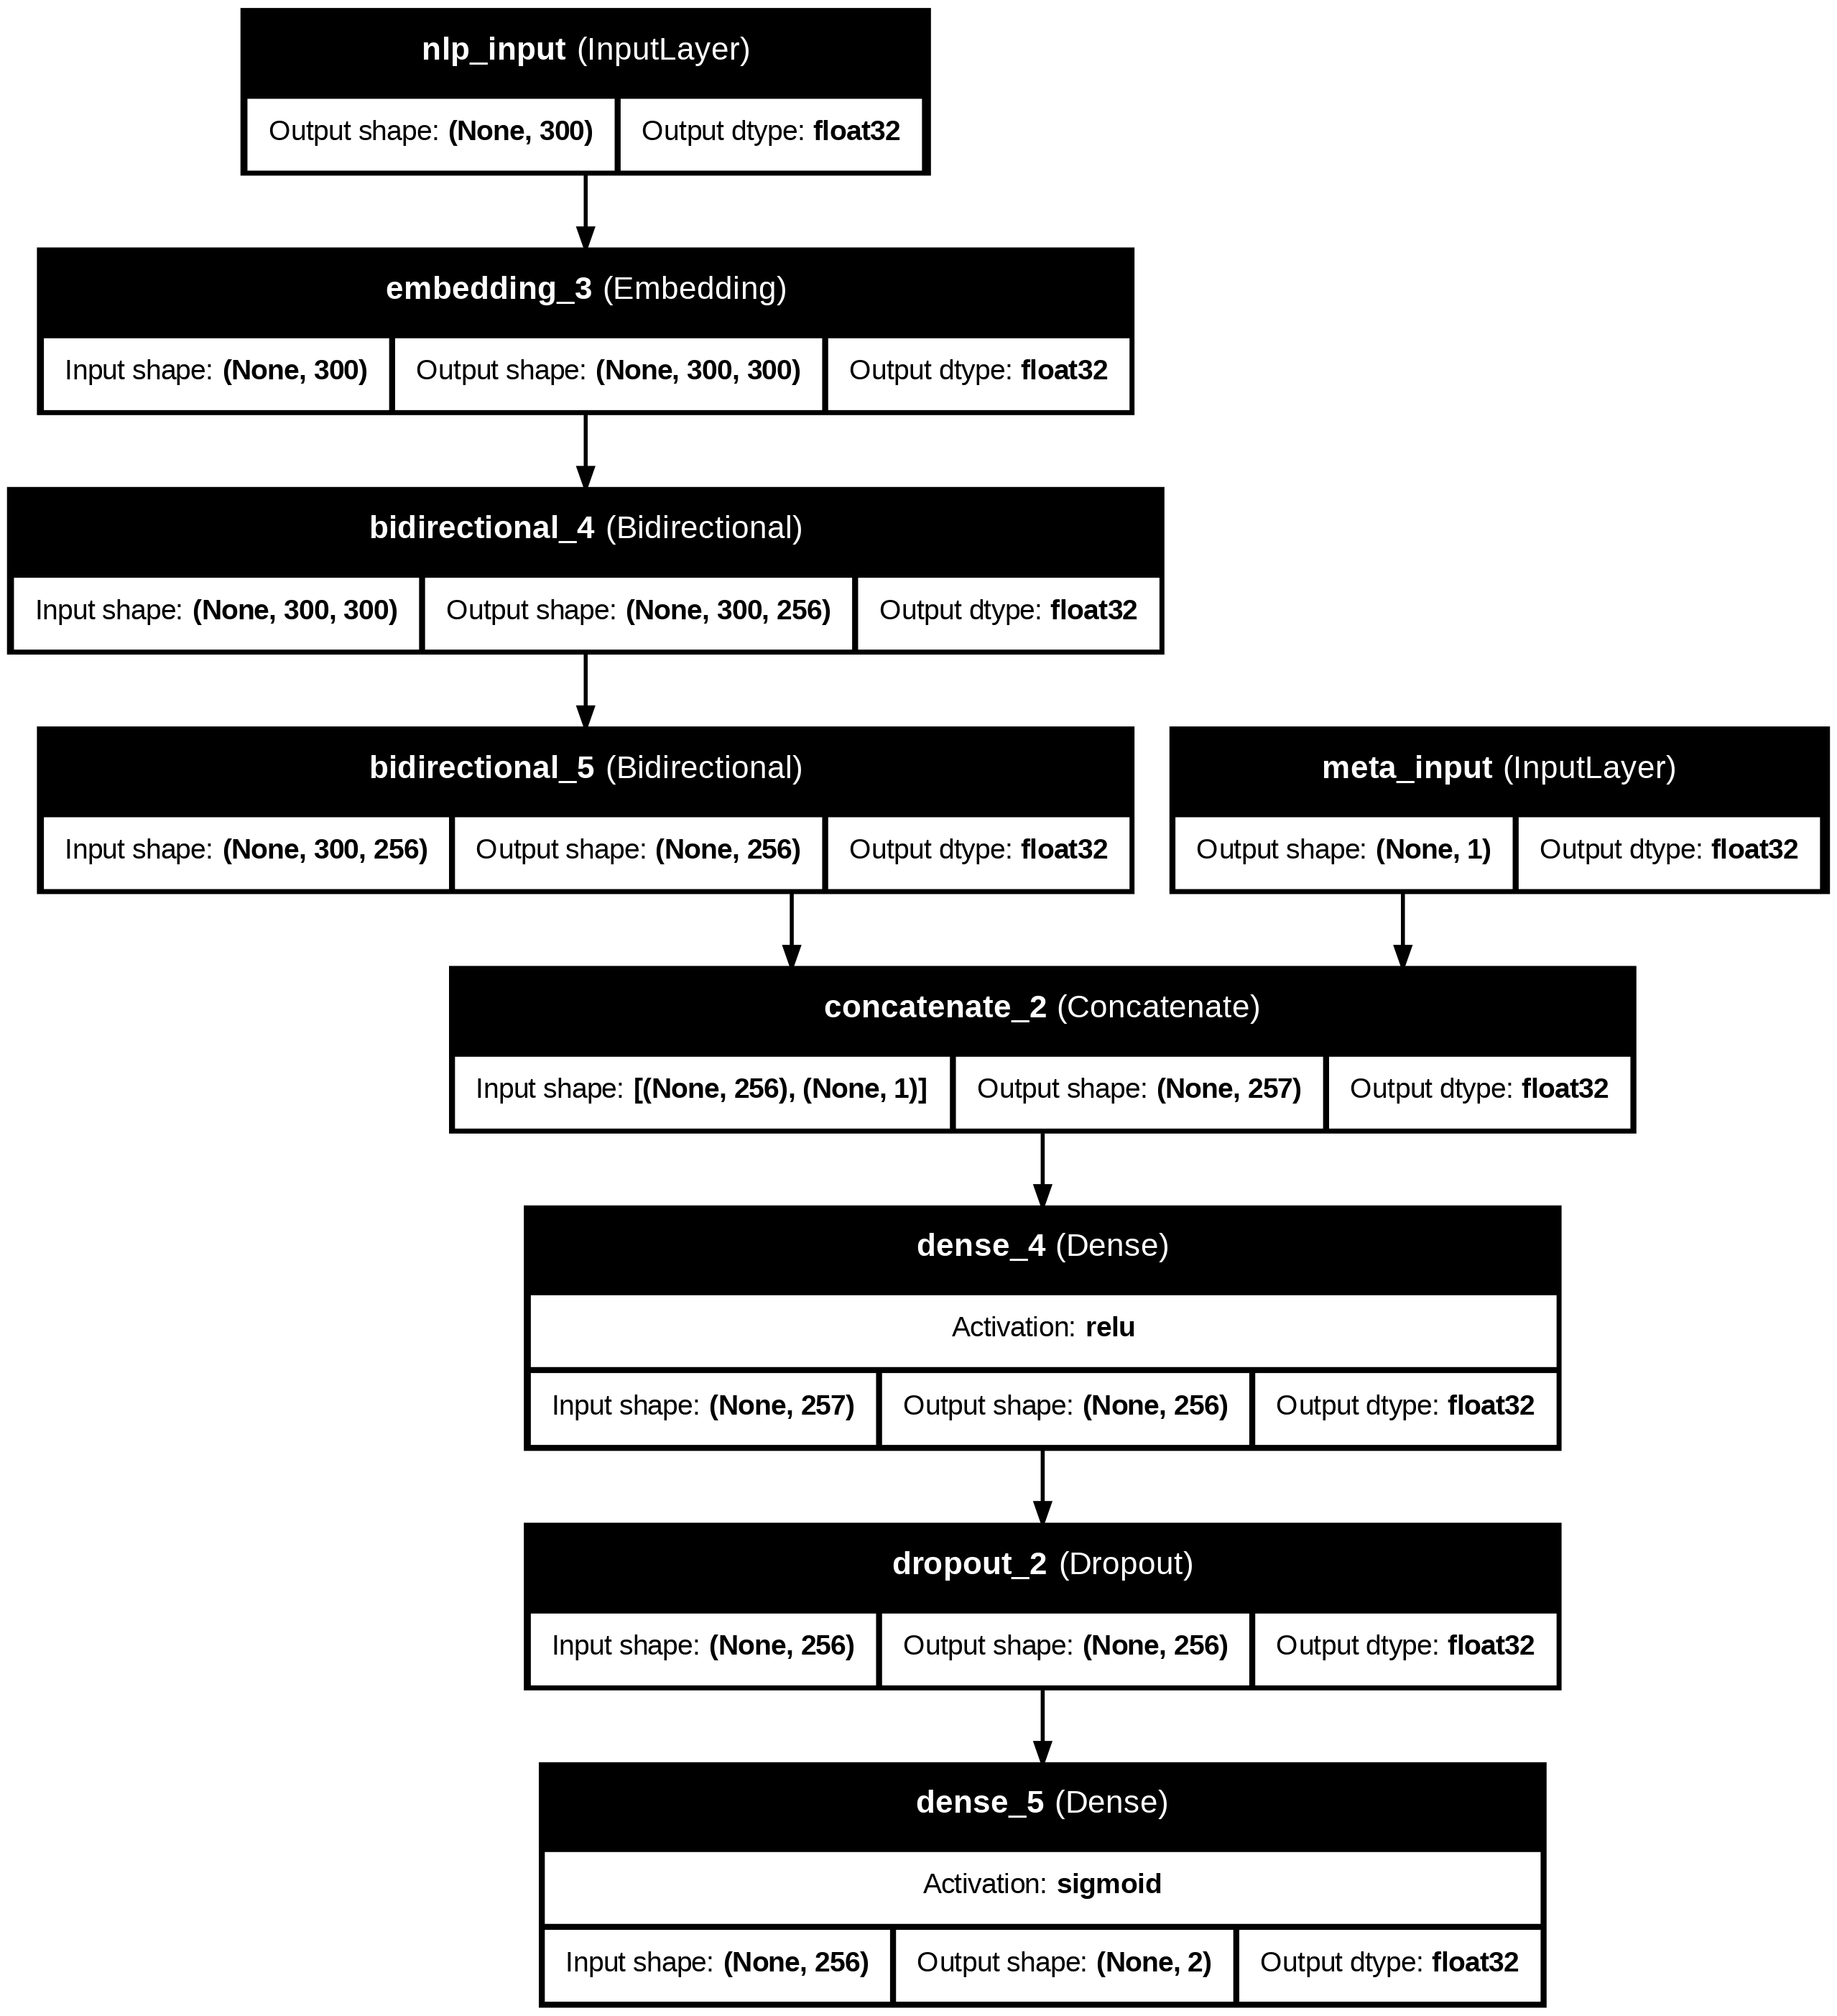

In [133]:
model_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file,
                          show_shapes=True,
                          show_layer_activations=True,
                          show_dtype=True,
                          show_layer_names=True )

In [134]:
%%time
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["AUC", "accuracy"])
history=model.fit([X_train_padded, X_Num_train_norm],[ytrain, y_Numtrain],batch_size = 512, epochs = 5, validation_data=([X_test_padded, X_Num_test_norm],[ytest,y_Numtest]))

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - AUC: 0.7388 - accuracy: 0.7099 - loss: 13.6693 - val_AUC: 0.8195 - val_accuracy: 0.7719 - val_loss: 5.4186
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - AUC: 0.7743 - accuracy: 0.7621 - loss: 4.1304 - val_AUC: 0.8338 - val_accuracy: 0.7709 - val_loss: 1.5872
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - AUC: 0.8809 - accuracy: 0.8199 - loss: 1.2081 - val_AUC: 0.9097 - val_accuracy: 0.8270 - val_loss: 0.5833
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - AUC: 0.9393 - accuracy: 0.8774 - loss: 0.4510 - val_AUC: 0.9180 - val_accuracy: 0.8483 - val_loss: 0.4036
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - AUC: 0.9536 - accuracy: 0.8974 - loss: 0.3084 - val_AUC: 0.9168 - val_accuracy: 0.8490 - val_loss: 0.4146
CPU times: user 9min 14s, sys: 46.4 s, total: 10min
Wall time: 12min 4s


In [135]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    auc = history.history['accuracy']
    val_auc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(auc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, auc, 'b', label='Training accuracy')
    plt.plot(x, val_auc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

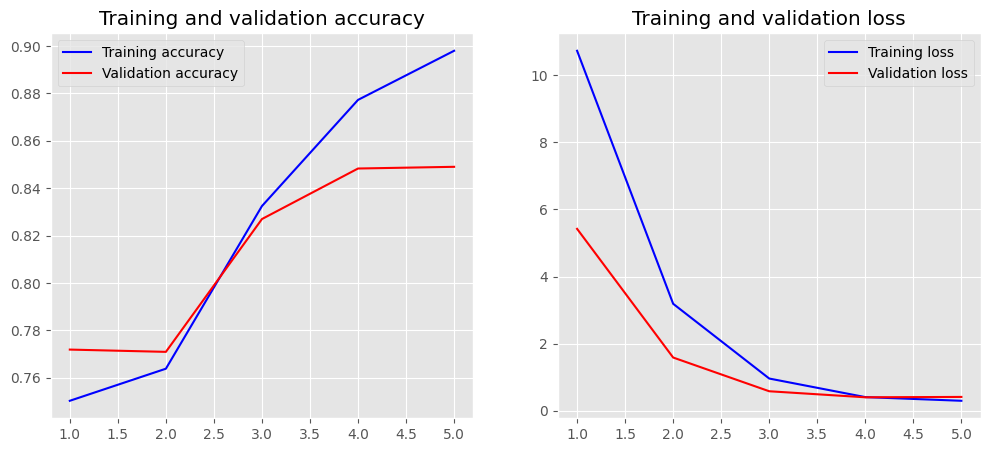

In [136]:
plot_history(history)

In [137]:
# Évaluer le modèle sur les données de test
test_loss, test_auc, test_accuracy = model.evaluate([X_test_padded, X_Num_test_norm], ytest)

# Afficher l'accuracy et l'AUC
print(f"Test AUC: {test_auc * 100:.4f}%")
print(f"Test Accuracy: {test_accuracy * 100:.4f}%")

131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 570ms/step - AUC: 0.9178 - accuracy: 0.8552 - loss: 0.4125
Test AUC: 91.6774%
Test Accuracy: 84.9029%


131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 624ms/step


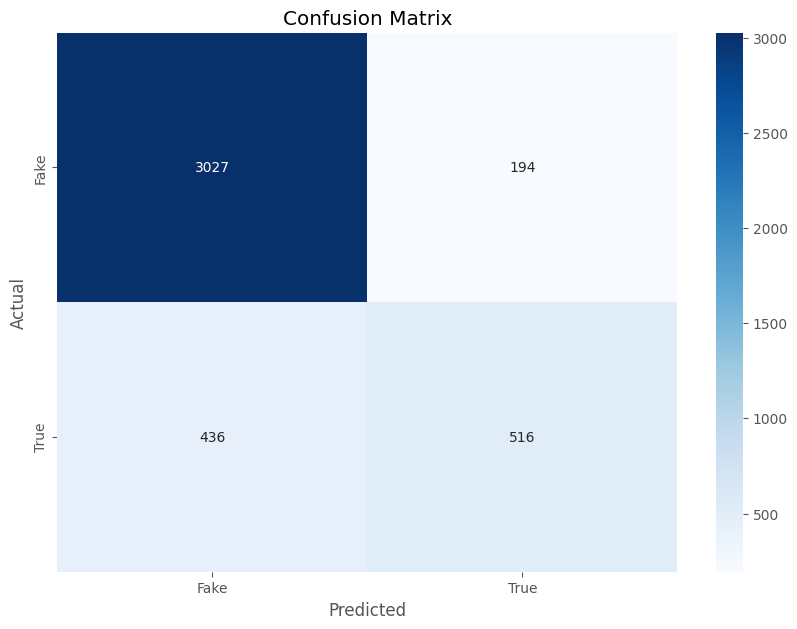

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics

# Convertir ytest en tableau NumPy si c'est un DataFrame
ytest_np = ytest.to_numpy()

# Séparation des données de test
nlp_test = X_test_padded  # Les séquences de texte prétraitées
meta_test = X_Num_test_norm  # Les métadonnées normalisées

# Prédiction avec le modèle
y_pred = model.predict([nlp_test, meta_test])

# Convertir les prédictions en tableau NumPy
y_pred_np = np.array(y_pred)

# Créer la matrice de confusion
cm = metrics.confusion_matrix(ytest_np.argmax(axis=1), y_pred_np.argmax(axis=1))

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Tracer la matrice de confusion
plot_confusion_matrix(cm, classes=['Fake', 'True'])


In [139]:
# Convert predicted probabilities to class labels
y_pred_np = np.argmax(y_pred_np, axis=1)  # Assuming your model outputs probabilities

# Ensure the true labels are in the same format (e.g., class labels, not one-hot encoded)
ytest_np = np.argmax(ytest_np, axis=1)  # If ytest_np is one-hot encoded, otherwise skip this

# Now you can generate the classification report
from sklearn.metrics import classification_report
print(classification_report(ytest_np, y_pred_np))


              precision    recall  f1-score   support

           0       0.87      0.94      0.91      3221
           1       0.73      0.54      0.62       952

    accuracy                           0.85      4173
   macro avg       0.80      0.74      0.76      4173
weighted avg       0.84      0.85      0.84      4173



In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(f"Accuracy of Bi-LSTM model, {accuracy_score(ytest_np, y_pred_np) * 100:.4f}%")
print(f"Precision of Bi-LSTM model, {precision_score(ytest_np, y_pred_np) * 100:.4f}%")
print(f"Recall of Bi-LSTM model, {recall_score(ytest_np, y_pred_np) * 100:.4f}%")
print(f"F1_score of Bi-LSTM model, {f1_score(ytest_np, y_pred_np) * 100:.4f}%")

Accuracy of Bi-LSTM model, 84.9029%
Precision of Bi-LSTM model, 72.6761%
Recall of Bi-LSTM model, 54.2017%
F1_score of Bi-LSTM model, 62.0939%
